In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def show_all(df, metric, plugin_metrics, plugin_models, matching_ks, rscore_models):
    plugin_cols = [f'{metric}_{pm}_{plugin_metric}' for plugin_metric in plugin_metrics for pm in plugin_models]
    matching_cols = [f'{metric}_match_{k}k_{plugin_metric}' for plugin_metric in plugin_metrics for k in matching_ks]
    rscore_cols = [f'{metric}_rs_{rs_bm}' for rs_bm in rscore_models]
    cols = ['name', f'{metric}_mse', f'{metric}_r2'] + plugin_cols + matching_cols + rscore_cols + [f'{metric}_val']
    return df[cols]

def show_all_jobs(df, metric, plugin_metrics, plugin_models, matching_ks, rscore_models):
    plugin_cols = [f'{metric}_{pm}_{plugin_metric}' for plugin_metric in plugin_metrics for pm in plugin_models]
    matching_cols = [f'{metric}_match_{k}k_{plugin_metric}' for plugin_metric in plugin_metrics for k in matching_ks]
    rscore_cols = [f'{metric}_rs_{rs_bm}' for rs_bm in rscore_models]
    cols = ['name', f'{metric}_mse', f'{metric}_r2', f'{metric}_pol'] + plugin_cols + matching_cols + rscore_cols + [f'{metric}_val']
    return df[cols]

In [3]:
def metric_name(x):
    if x['selection'] == 'MSE':
        return "$\mu{-risk}$"
    elif x['selection'] == 'R2':
        return "$\mu{-risk}_R$"
    elif x['selection'] == 'BEST':
        return "Oracle"
    elif x['selection'] == 'POL':
        return "$\mathcal{R}_{pol}$"
    else:
        ret = "$\\tau{-risk}"
        if x['selection'].startswith('RS'):
            ret += "_{R}$"
        elif x['selection'].startswith('MATCH'):
            ret += "_{match}"
        else:
            ret += "_{plug}"
        
        if x['selection'].endswith('ATE'):
            ret += "^{ATE}$"
        elif x['selection'].endswith('PEHE'):
            ret += "^{PEHE}$"
        
        return ret

In [4]:
def base_name(x):
    if x['selection'] in ['MSE', 'R2', 'BEST', 'POL']:
        return 'N/A'
    elif x['selection'].startswith('MATCH'):
        return 'N/A'
    else:
        return x['selection'].split('-')[1]
        

In [5]:
plugin_meta_models = ['sl', 'tl']
plugin_base_models = ['dt', 'lgbm', 'kr']
plugin_models = [f'{pmm}_{pbm}' for pmm in plugin_meta_models for pbm in plugin_base_models]
matching_ks = [1, 3, 5]
rscore_base_models = ['dt', 'lgbm', 'kr']

In [8]:
def plot_metrics(ds, avg_metric, ite_metric, ax=None, legend=False, s=40):
    df_all = pd.read_csv(f'./tables/{ds}_compare_metrics_all_val_raw.csv')
    df_ate = show_all(df_all, avg_metric, ['ate', 'pehe'], plugin_models, matching_ks, rscore_base_models)
    df_pehe = show_all(df_all, ite_metric, ['ate', 'pehe'], plugin_models, matching_ks, rscore_base_models)

    selection_models = [f'{pmm}_{pbm}_{pm}' for pmm in plugin_meta_models for pbm in plugin_base_models for pm in ['ate', 'pehe']] + [f'match_{k}k_{pm}' for k in matching_ks for pm in ['ate', 'pehe']] + [f'rs_{rbm}' for rbm in rscore_base_models]
    d_ate = {f'{avg_metric}_val': 'best', f'{avg_metric}_mse': 'mse', f'{avg_metric}_r2': 'r2'}
    d_pehe = {f'{ite_metric}_val': 'best', f'{ite_metric}_mse': 'mse', f'{ite_metric}_r2': 'r2'}
    for sm in selection_models:
        d_ate[f'{avg_metric}_{sm}'] = sm
        d_pehe[f'{ite_metric}_{sm}'] = sm

    df_ate = df_ate.rename(columns=d_ate)
    df_pehe = df_pehe.rename(columns=d_pehe)

    df_ate = df_ate.set_index('name').T
    df_pehe = df_pehe.set_index('name').T

    df_final = df_ate.merge(df_pehe, left_index=True, right_index=True, suffixes=['_ate', '_pehe']).reset_index()

    # Add an empty policy row for compatibility with Jobs dataset
    df_final.loc[1.5] = 'pol', None, None
    df_final = df_final.sort_index().reset_index(drop=True)

    df_final['selection'] = df_final['index'].apply(lambda x: x.upper().replace('_', '-'))

    df_final['metric'] = df_final.apply(metric_name, axis=1)
    df_final['learner'] = df_final.apply(base_name, axis=1)

    if ax:
        sns.scatterplot(data=df_final, x='all_ate', y='all_pehe', hue='metric', style='learner', ax=ax, legend=legend, s=s)
    else:
        sns.scatterplot(data=df_final, x='all_ate', y='all_pehe', hue='metric', style='learner', legend=legend, s=s)

In [9]:
def plot_metrics_jobs(ds, avg_metric, ite_metric, ax=None, legend=False, s=40):
    df_all = pd.read_csv(f'./tables/{ds}_compare_metrics_all_val_raw.csv')
    df_ate = show_all_jobs(df_all, avg_metric, ['ate', 'pehe'], plugin_models, matching_ks, rscore_base_models)
    df_pehe = show_all_jobs(df_all, ite_metric, ['ate', 'pehe'], plugin_models, matching_ks, rscore_base_models)

    selection_models = [f'{pmm}_{pbm}_{pm}' for pmm in plugin_meta_models for pbm in plugin_base_models for pm in ['ate', 'pehe']] + [f'match_{k}k_{pm}' for k in matching_ks for pm in ['ate', 'pehe']] + [f'rs_{rbm}' for rbm in rscore_base_models]
    d_ate = {f'{avg_metric}_val': 'best', f'{avg_metric}_mse': 'mse', f'{avg_metric}_r2': 'r2', f'{avg_metric}_pol': 'pol'}
    d_pehe = {f'{ite_metric}_val': 'best', f'{ite_metric}_mse': 'mse', f'{ite_metric}_r2': 'r2', f'{ite_metric}_pol': 'pol'}
    for sm in selection_models:
        d_ate[f'{avg_metric}_{sm}'] = sm
        d_pehe[f'{ite_metric}_{sm}'] = sm

    df_ate = df_ate.rename(columns=d_ate)
    df_pehe = df_pehe.rename(columns=d_pehe)

    df_ate = df_ate.set_index('name').T
    df_pehe = df_pehe.set_index('name').T

    df_final = df_ate.merge(df_pehe, left_index=True, right_index=True, suffixes=['_att', '_pol']).reset_index()
    df_final['selection'] = df_final['index'].apply(lambda x: x.upper().replace('_', '-'))

    df_final['metric'] = df_final.apply(metric_name, axis=1)
    df_final['learner'] = df_final.apply(base_name, axis=1)

    if ax:
        sns.scatterplot(data=df_final, x='all_att', y='all_pol', hue='metric', style='learner', ax=ax, legend=legend, s=s)
    else:
        sns.scatterplot(data=df_final, x='all_att', y='all_pol', hue='metric', style='learner', legend=legend, s=s)

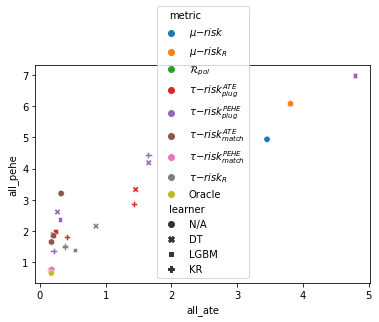

In [9]:
ds = 'ihdp'
avg_metric = 'ate'
ite_metric = 'pehe'

plot_metrics(ds, avg_metric, ite_metric, legend=True)

## All

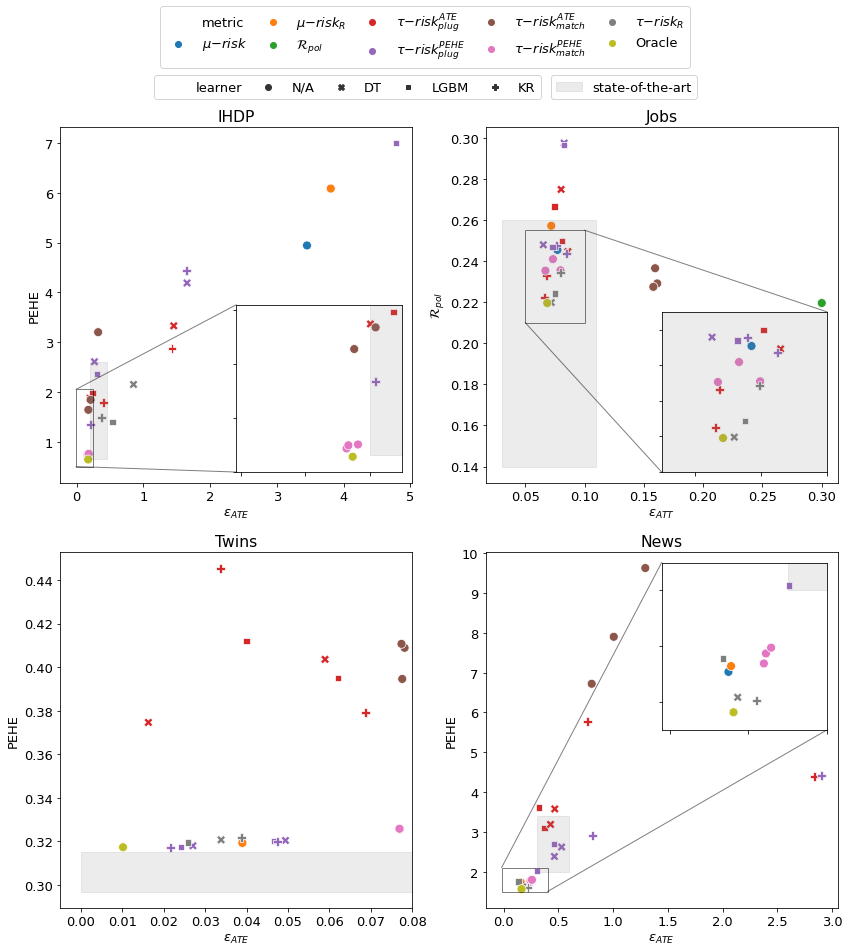

In [11]:
p_size = 80
sota_color = 'grey'
sota_alpha = 0.15

plt.rcParams.update({'font.size': 13})
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

ax = axs[0][0]
ds = 'ihdp'
avg_metric = 'ate'
ite_metric = 'pehe'

plot_metrics(ds, avg_metric, ite_metric, ax, False, s=p_size)
ax.set_title('IHDP')
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('PEHE')
ax.fill_between([0.2, 0.46], 0.656, 2.6, alpha=sota_alpha, color=sota_color)
axins = ax.inset_axes([0.5, 0.03, 0.47, 0.47])
plot_metrics(ds, avg_metric, ite_metric, axins, s=p_size)
axins.set_xlim(-0.008, 0.25)
axins.set_ylim(0.5, 2.05)
axins.fill_between([0.2, 0.46], 0.656, 2.6, alpha=sota_alpha, color=sota_color)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xlabel('')
axins.set_ylabel('')
ax.indicate_inset_zoom(axins, edgecolor="black")

ax = axs[0][1]
ds = 'jobs'
avg_metric = 'att'
ite_metric = 'policy'

plot_metrics_jobs(ds, avg_metric, ite_metric, ax, False, s=p_size)
ax.set_title('Jobs')
ax.set_xlabel('$\epsilon_{ATT}$')
ax.set_ylabel('$\mathcal{R}_{pol}$')
ax.fill_between([0.03, 0.11], 0.14, 0.26, alpha=sota_alpha, color=sota_color)
axins = ax.inset_axes([0.5, 0.03, 0.47, 0.45])
plot_metrics_jobs(ds, avg_metric, ite_metric, axins, s=p_size)
axins.set_xlim(0.05, 0.1)
axins.set_ylim(0.21, 0.255)
axins.fill_between([0.03, 0.11], 0.14, 0.26, alpha=sota_alpha, color=sota_color)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xlabel('')
axins.set_ylabel('')
ax.indicate_inset_zoom(axins, edgecolor="black")

ax = axs[1][0]
ds = 'twins'
avg_metric = 'ate'
ite_metric = 'pehe'

plot_metrics(ds, avg_metric, ite_metric, ax, False, s=p_size)
ax.set_title('Twins')
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('PEHE')
ax.fill_between([0.0, 0.1], 0.297, 0.315, alpha=sota_alpha, color=sota_color)
ax.set_xlim(right=0.08)

ax = axs[1][1]
ds = 'news'

plot_metrics(ds, avg_metric, ite_metric, ax, True, s=p_size)
ax.set_title('News')
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('PEHE')
sota_obj = ax.fill_between([0.3, 0.6], 2.0, 3.4, alpha=sota_alpha, color=sota_color)
axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])
plot_metrics(ds, avg_metric, ite_metric, axins, s=p_size)
axins.set_xlim(-0.02, 0.4)
axins.set_ylim(1.5, 2.1)
axins.fill_between([0.3, 0.6], 2.0, 3.4, alpha=sota_alpha, color=sota_color)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xlabel('')
axins.set_ylabel('')
ax.indicate_inset_zoom(axins, edgecolor="black")


lines, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
lines1 = lines[:10]
lines2 = lines[10:]
labels1 = labels[:10]
labels2 = labels[10:]
fig.legend(lines1, labels1, loc='upper center', ncol=len(labels1)//2, bbox_to_anchor=(0.5, 1.11), columnspacing=1)
fig.legend(lines2, labels2, loc='upper center', ncol=len(labels2), bbox_to_anchor=(0.41, 1.03), columnspacing=1)
fig.legend([sota_obj], ['state-of-the-art'], loc='upper center', bbox_to_anchor=(0.73, 1.03))

plt.tight_layout()
plt.savefig('metrics_all.pdf', dpi=1000, bbox_inches="tight")

## Focused

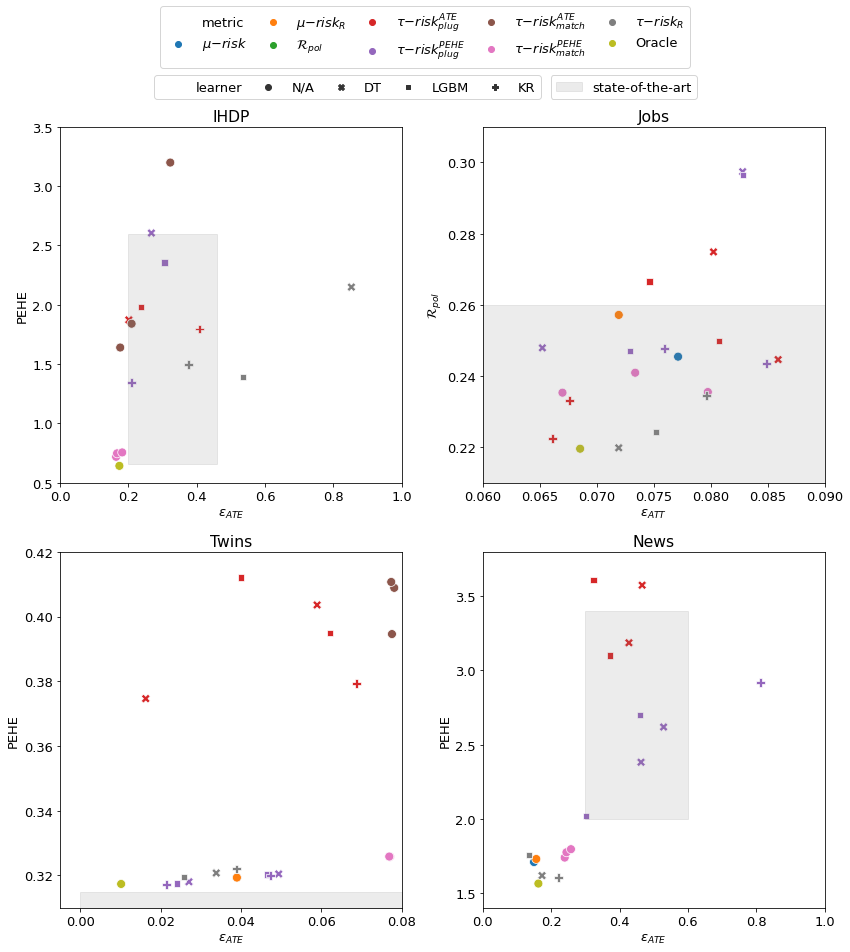

In [21]:
p_size = 80
sota_color = 'grey'
sota_alpha = 0.15

plt.rcParams.update({'font.size': 13})
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

ax = axs[0][0]
ds = 'ihdp'
avg_metric = 'ate'
ite_metric = 'pehe'

plot_metrics(ds, avg_metric, ite_metric, ax, False, s=p_size)
ax.set_title('IHDP')
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('PEHE')
ax.fill_between([0.2, 0.46], 0.656, 2.6, alpha=sota_alpha, color=sota_color)
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.5, 3.5)

ax = axs[0][1]
ds = 'jobs'
avg_metric = 'att'
ite_metric = 'policy'

plot_metrics_jobs(ds, avg_metric, ite_metric, ax, False, s=p_size)
ax.set_title('Jobs')
ax.set_xlabel('$\epsilon_{ATT}$')
ax.set_ylabel('$\mathcal{R}_{pol}$')
ax.fill_between([0.03, 0.11], 0.14, 0.26, alpha=sota_alpha, color=sota_color)
ax.set_xlim(0.06, 0.09)
ax.set_ylim(0.21, 0.31)

ax = axs[1][0]
ds = 'twins'
avg_metric = 'ate'
ite_metric = 'pehe'

plot_metrics(ds, avg_metric, ite_metric, ax, False, s=p_size)
ax.set_title('Twins')
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('PEHE')
ax.fill_between([0.0, 0.1], 0.297, 0.315, alpha=sota_alpha, color=sota_color)
ax.set_xlim(right=0.08)
ax.set_ylim(0.31, 0.42)

ax = axs[1][1]
ds = 'news'

plot_metrics(ds, avg_metric, ite_metric, ax, True, s=p_size)
ax.set_title('News')
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('PEHE')
sota_obj = ax.fill_between([0.3, 0.6], 2.0, 3.4, alpha=sota_alpha, color=sota_color)
ax.set_xlim(0.0, 1.0)
ax.set_ylim(1.4, 3.8)


lines, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
lines1 = lines[:10]
lines2 = lines[10:]
labels1 = labels[:10]
labels2 = labels[10:]
fig.legend(lines1, labels1, loc='upper center', ncol=len(labels1)//2, bbox_to_anchor=(0.5, 1.11), columnspacing=1)
fig.legend(lines2, labels2, loc='upper center', ncol=len(labels2), bbox_to_anchor=(0.41, 1.03), columnspacing=1)
fig.legend([sota_obj], ['state-of-the-art'], loc='upper center', bbox_to_anchor=(0.73, 1.03))

plt.tight_layout()
plt.savefig('metrics_focused.pdf', dpi=1000, bbox_inches="tight")

## IHDP and Jobs

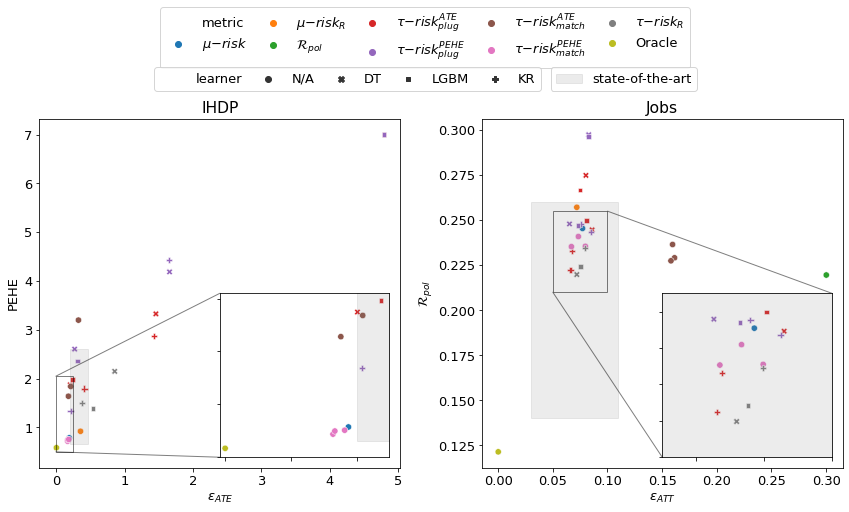

In [18]:
sota_color = 'grey'
sota_alpha = 0.15

plt.rcParams.update({'font.size': 13})
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

ax = axs[0]
ds = 'ihdp'
avg_metric = 'ate'
ite_metric = 'pehe'

plot_metrics(ds, avg_metric, ite_metric, ax, False)
ax.set_title('IHDP')
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('PEHE')
ax.fill_between([0.2, 0.46], 0.656, 2.6, alpha=sota_alpha, color=sota_color)
axins = ax.inset_axes([0.5, 0.03, 0.47, 0.47])
plot_metrics(ds, avg_metric, ite_metric, axins)
axins.set_xlim(-0.008, 0.25)
axins.set_ylim(0.5, 2.05)
axins.fill_between([0.2, 0.46], 0.656, 2.6, alpha=sota_alpha, color=sota_color)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xlabel('')
axins.set_ylabel('')
ax.indicate_inset_zoom(axins, edgecolor="black")

ax = axs[1]
ds = 'jobs'
avg_metric = 'att'
ite_metric = 'policy'

plot_metrics_jobs(ds, avg_metric, ite_metric, ax, True)
ax.set_title('Jobs')
ax.set_xlabel('$\epsilon_{ATT}$')
ax.set_ylabel('$\mathcal{R}_{pol}$')
sota_obj = ax.fill_between([0.03, 0.11], 0.14, 0.26, alpha=sota_alpha, color=sota_color)
axins = ax.inset_axes([0.5, 0.03, 0.47, 0.47])
plot_metrics_jobs(ds, avg_metric, ite_metric, axins)
axins.set_xlim(0.05, 0.1)
axins.set_ylim(0.21, 0.255)
axins.fill_between([0.03, 0.11], 0.14, 0.26, alpha=sota_alpha, color=sota_color)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xlabel('')
axins.set_ylabel('')
ax.indicate_inset_zoom(axins, edgecolor="black")


lines, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
lines1 = lines[:10]
lines2 = lines[10:]
labels1 = labels[:10]
labels2 = labels[10:]
fig.legend(lines1, labels1, loc='upper center', ncol=len(labels1)//2, bbox_to_anchor=(0.5, 1.2), columnspacing=1)
fig.legend(lines2, labels2, loc='upper center', ncol=len(labels2), bbox_to_anchor=(0.41, 1.06), columnspacing=1)
fig.legend([sota_obj], ['state-of-the-art'], loc='upper center', bbox_to_anchor=(0.73, 1.06))

plt.tight_layout()
plt.savefig('metrics_ihdp_jobs.pdf', dpi=1000, bbox_inches="tight")

## Twins and News

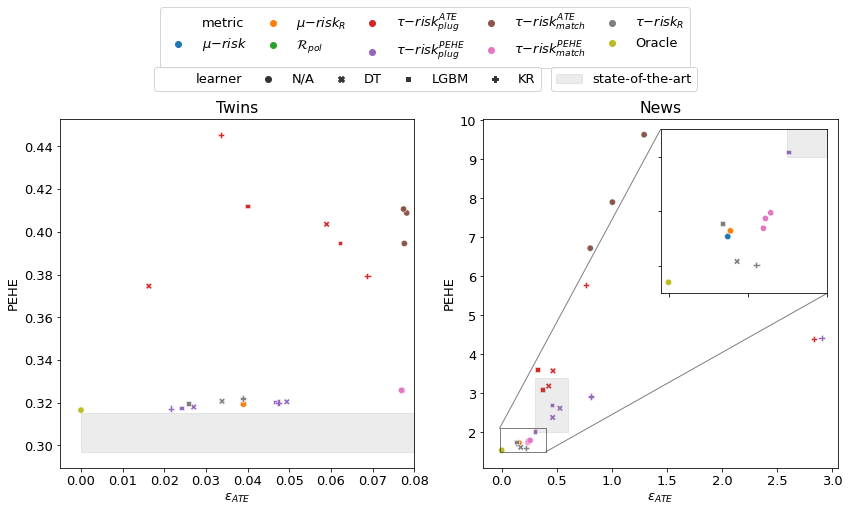

In [20]:
sota_color = 'grey'
sota_alpha = 0.15

plt.rcParams.update({'font.size': 13})
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

ax = axs[0]
ds = 'twins'
avg_metric = 'ate'
ite_metric = 'pehe'

plot_metrics(ds, avg_metric, ite_metric, ax, False)
ax.set_title('Twins')
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('PEHE')
ax.fill_between([0.0, 0.1], 0.297, 0.315, alpha=sota_alpha, color=sota_color)
ax.set_xlim(right=0.08)

ax = axs[1]
ds = 'news'

plot_metrics(ds, avg_metric, ite_metric, ax, True)
ax.set_title('News')
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('PEHE')
sota_obj = ax.fill_between([0.3, 0.6], 2.0, 3.4, alpha=sota_alpha, color=sota_color)
axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])
plot_metrics(ds, avg_metric, ite_metric, axins)
axins.set_xlim(-0.02, 0.4)
axins.set_ylim(1.5, 2.1)
axins.fill_between([0.3, 0.6], 2.0, 3.4, alpha=sota_alpha, color=sota_color)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xlabel('')
axins.set_ylabel('')
ax.indicate_inset_zoom(axins, edgecolor="black")


lines, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
lines1 = lines[:10]
lines2 = lines[10:]
labels1 = labels[:10]
labels2 = labels[10:]
fig.legend(lines1, labels1, loc='upper center', ncol=len(labels1)//2, bbox_to_anchor=(0.5, 1.2), columnspacing=1)
fig.legend(lines2, labels2, loc='upper center', ncol=len(labels2), bbox_to_anchor=(0.41, 1.06), columnspacing=1)
fig.legend([sota_obj], ['state-of-the-art'], loc='upper center', bbox_to_anchor=(0.73, 1.06))

plt.tight_layout()
plt.savefig('metrics_twins_news.pdf', dpi=1000, bbox_inches="tight")